In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

The goal of this project is to develop a system that can look at images of handwritten cursive letters and accurately identify which letter each image represents. The customer wants a tool that can process many different handwritten samples, including different handwriting styles, and automatically recognize each letter the image is showing.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

The dataset was provided as a zip file containing around 2000 images of different letters that are labeled by what letter the image represents and how many of that letter has shown up. The fact that the dataset is handwritten images will make recognition more challenging due to the natural variations in handwriting style.

In [11]:
import os
import zipfile
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


ZIP_PATH = "archive.zip"                 
EXTRACT_PATH = "extracted_images"        
CONVERTED_PATH = "converted_images"      
IMAGE_SIZE = (250, 250)

os.makedirs(EXTRACT_PATH, exist_ok=True)
print("Extracting dataset from ZIP")
with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)
print("Extraction complete.\n")

# Convert pngs to grayscale + resize
os.makedirs(CONVERTED_PATH, exist_ok=True)
count_converted = 0
for root, _, files in os.walk(EXTRACT_PATH):
    for f in files:
        if f.lower().endswith(".png"):
            src = os.path.join(root, f)
            target_path = os.path.join(CONVERTED_PATH, f.rsplit('.', 1)[0] + ".png")
            try:
                img = Image.open(src).convert("L").resize(IMAGE_SIZE)
                img.save(target_path, "PNG", optimize=True)
                count_converted += 1
            except:
                continue
print(f"{count_converted} PNG images converted and resized.\n")

Extracting dataset from ZIP
Extraction complete.

2070 PNG images converted and resized.



# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

After extracting the zip file, I explored the dataset and verified the number of samples per letter. Each letter had a varying amount, so there was some bias towards some letter like a and e because they had hundred of examples while letters like z and j had very few. I also standardized each image to grayscale and made them all 250x250 to give consistency in all the images. I used graphs to display image count per letter, graphed the mean grayscale value/average brightness, and printed some examples of the images in the dataset.

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Loaded 1992 total images across 27 unique letters.



/tmp/ipykernel_4176405/3770751222.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", order=sorted(df["label"].unique()), palette="viridis")


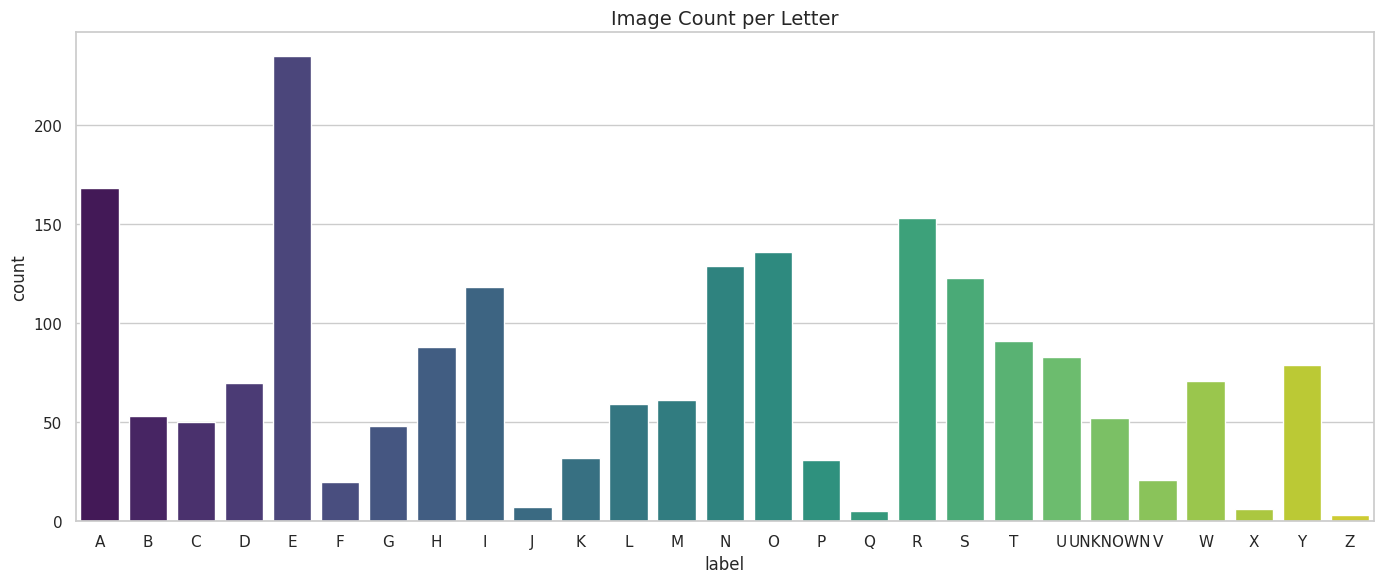

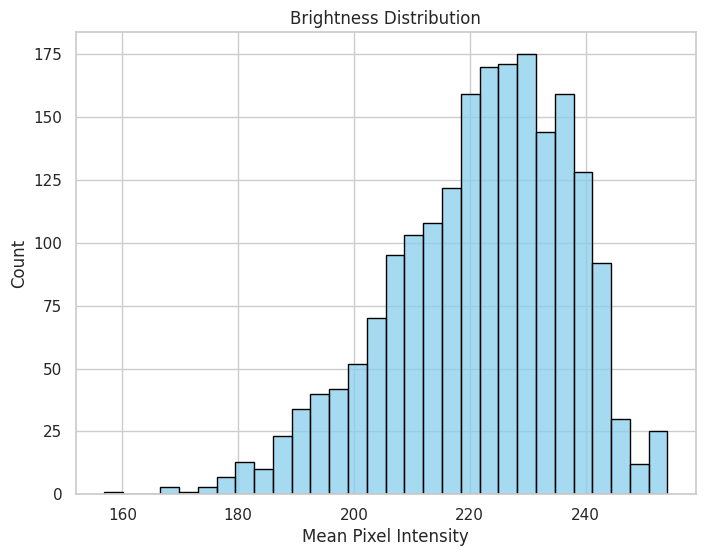

Displaying sample images...


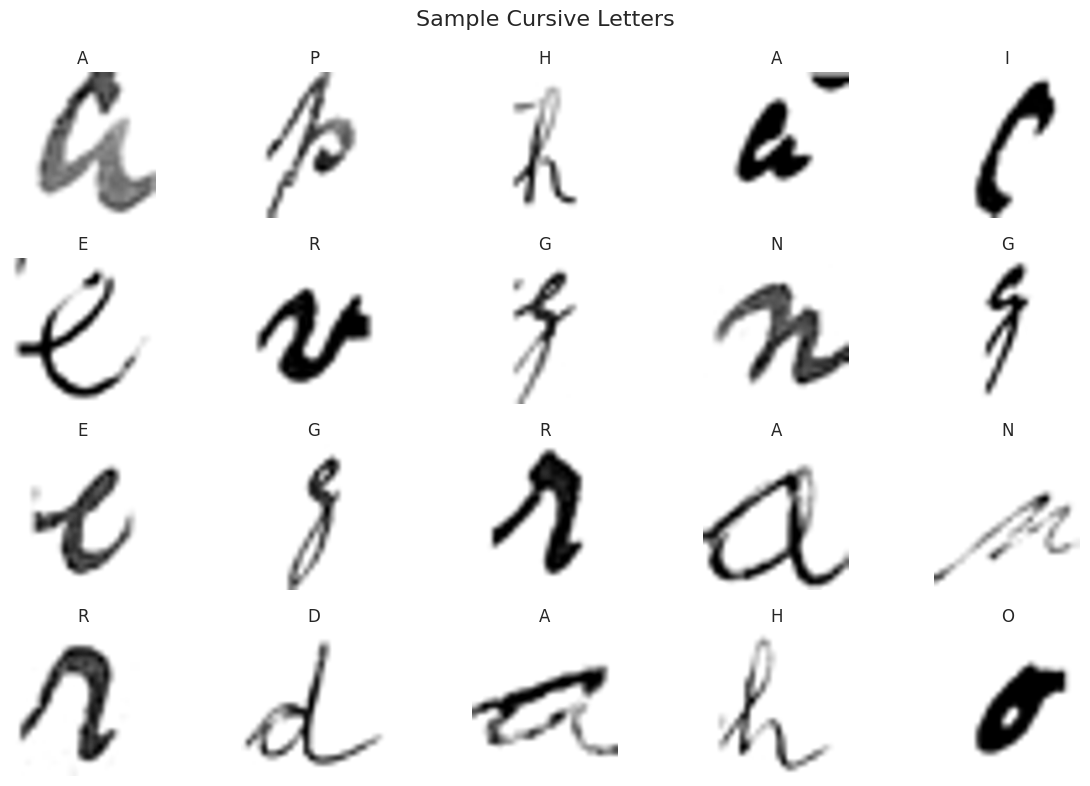

In [12]:
sns.set(style="whitegrid")

data = []
labels = []
records = []

for root, _, files in os.walk(CONVERTED_PATH):
    for f in files:
        if f.lower().endswith(".png"):
            path = os.path.join(root, f)

            # Extract letter label from filename
            name = os.path.splitext(f)[0]
            label = name.split("_")[-1].upper() if "_" in name else "UNKNOWN"

            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, IMAGE_SIZE)

            data.append(img)
            labels.append(label)
            records.append({
                "filepath": path,
                "label": label,
                "width": img.shape[1],
                "height": img.shape[0],
                "brightness": np.mean(img)
            })

df = pd.DataFrame(records)
data = np.array(data).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1) / 255.0
labels = np.array(labels)

print(f"Loaded {len(data)} total images across {len(np.unique(labels))} unique letters.\n")

#Image count per letter
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x="label", order=sorted(df["label"].unique()), palette="viridis")
plt.title("Image Count per Letter", fontsize=14)
plt.tight_layout()
plt.show()

#Brightness distribution
plt.figure(figsize=(8, 6))
sns.histplot(df["brightness"], bins=30, color="skyblue", edgecolor="black")
plt.title("Brightness Distribution")
plt.xlabel("Mean Pixel Intensity")
plt.show()

#Display sample images
print("Displaying sample images...")
sample_df = df.sample(min(20, len(df)))
plt.figure(figsize=(12, 8))
for i, row in enumerate(sample_df.itertuples()):
    img = cv2.imread(row.filepath, cv2.IMREAD_GRAYSCALE)
    plt.subplot(4, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(row.label)
    plt.axis("off")
plt.suptitle("Sample Cursive Letters", fontsize=16)
plt.tight_layout()
plt.show()

# 4.Prepare the Data


Apply any data transformations and explain what and why


In this step, I prepared the handwritten cursive letter images for modeling. I encoded each folder to switch the alphabet labels to numerical because models work in number rather than letters. I normalized the pixels in the image to be from 0 to 1 instead of 0 to 255. Then I split the data into 80% training data and 20% testing data.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    data, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Unique letters: {len(encoder.classes_)}\n")

np.savez_compressed(
    "cursive_dataset_splits_80_20.npz",
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test
)

Training samples: 1593
Testing samples: 399
Unique letters: 27



# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


I experimented with 3 different machine learning models. Before training I used PCA (Principal Component Analysis) to reduce the number of features from 62500 to around a 100, so that only the most important patterns were left for each image and the unnecessary noise was gone. Logistic regression was the weakest model and Random Forest and SVM performed similarly, but SVM was a bit higher at an accuracy of 60%. SVM is the model that I will go into the fine tuning step with.

Training Logistic Regression


/opt/tljh/user/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.4712

Training Random Forest
Random Forest Accuracy: 0.6015

Training SVM
SVM (Linear Kernel) Accuracy: 0.6065



/tmp/ipykernel_4176405/551933965.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="mako")


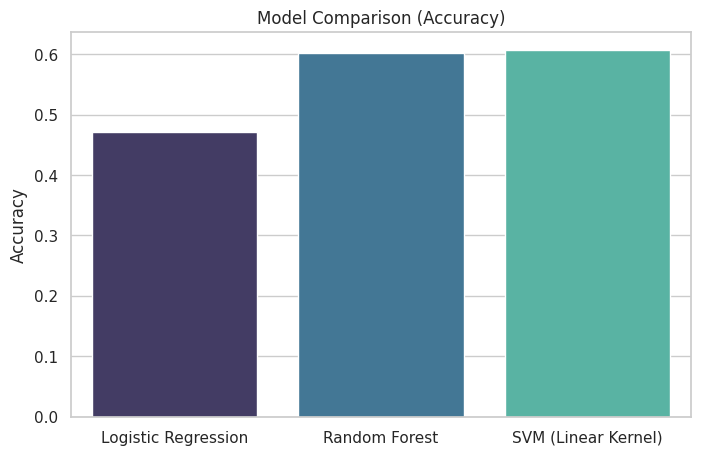

best model so far: SVM (Linear Kernel) with accuracy 0.6065



In [14]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

#Flatten images for PCA
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

results = {}

print("Training Logistic Regression")
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_pca, y_train)
preds_lr = lr.predict(X_test_pca)
acc_lr = accuracy_score(y_test, preds_lr)
results["Logistic Regression"] = acc_lr
print(f"Logistic Regression Accuracy: {acc_lr:.4f}\n")

print("Training Random Forest")
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_pca, y_train)
preds_rf = rf.predict(X_test_pca)
acc_rf = accuracy_score(y_test, preds_rf)
results["Random Forest"] = acc_rf
print(f"Random Forest Accuracy: {acc_rf:.4f}\n")

print("Training SVM")
svm = SVC(kernel="linear", random_state=42)
svm.fit(X_train_pca, y_train)
preds_svm = svm.predict(X_test_pca)
acc_svm = accuracy_score(y_test, preds_svm)
results["SVM (Linear Kernel)"] = acc_svm
print(f"SVM (Linear Kernel) Accuracy: {acc_svm:.4f}\n")

#Compare model performance
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="mako")
plt.title("Model Comparison (Accuracy)")
plt.ylabel("Accuracy")
plt.show()

best_model_name = max(results, key=results.get)
print(f"best model so far: {best_model_name} with accuracy {results[best_model_name]:.4f}\n")


# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


I fine tuned the best model, which was SVM using Grid Search, which tests different settings to get the most accurate combo. After fine tuning the accuracy went up by 1%. I displayed a classification report that shows how well if identified each letter. Since there was such variation in images between each letter it seemed that for letters with the highest number of data it averaged at around 61 to 64% accuracy. Since some letters like j did not have much data that was not very reliable. I also displayed a confusion matrix to see what letter each letter was confused with and it can again be seen there is a strong correlation between amount of data and the final accuracy of around 60%.


Fine-tuning SVM (Linear Kernel)
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fine-tuned SVM (Linear Kernel) Accuracy: 0.6065

Classification Report:
               precision    recall  f1-score   support

           A       0.61      0.79      0.69        34
           B       0.44      0.36      0.40        11
           C       0.44      0.40      0.42        10
           D       0.56      0.64      0.60        14
           E       0.64      0.81      0.72        47
           F       0.25      0.25      0.25         4
           G       0.47      0.80      0.59        10
           H       0.44      0.22      0.30        18
           I       0.43      0.38      0.40        24
           J       1.00      1.00      1.00         1
           K       0.33      0.50      0.40         6
           L       0.33      0.25      0.29        12
           M       0.60      0.75      0.67        12
           N       0.61      0.65      0.63        26
           O       0.71  

/opt/tljh/user/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/tljh/user/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/tljh/user/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


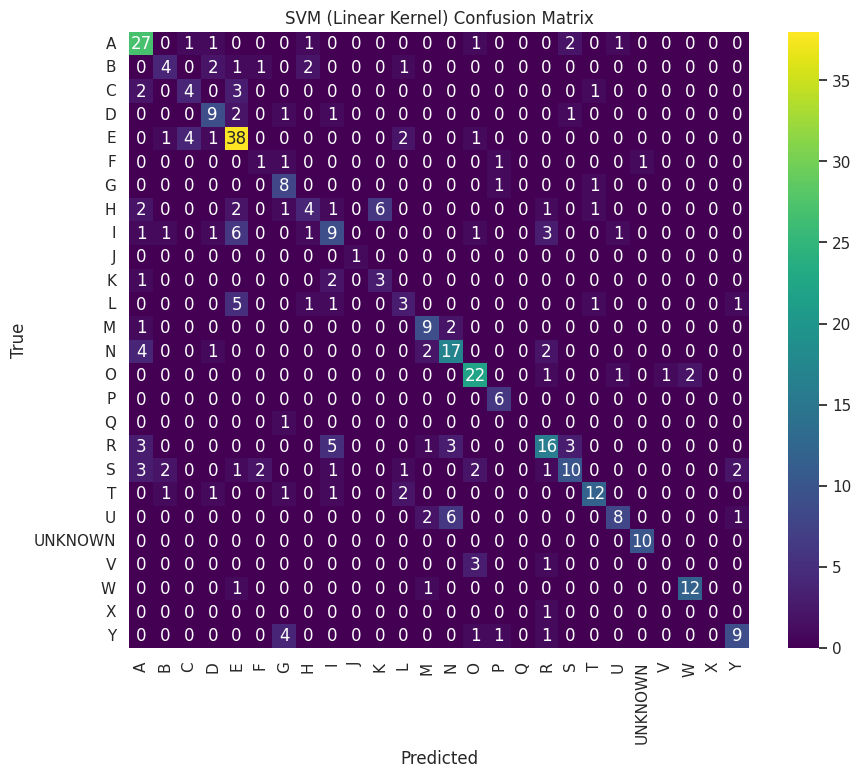

['label_encoder.joblib']

In [17]:
from sklearn.metrics import confusion_matrix

if best_model_name == "SVM (Linear Kernel)":
    model = svm
    param_grid = {"C": [0.1, 1, 5]}
elif best_model_name == "Random Forest":
    model = rf
    param_grid = {"n_estimators": [100, 200, 300], "max_depth": [None, 10, 20]}
else:
    model = lr
    param_grid = {"C": [0.01, 0.1, 1, 5]}

print(f"Fine-tuning {best_model_name}")
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train_pca, y_train)

best_model = grid.best_estimator_
preds = best_model.predict(X_test_pca)
acc = accuracy_score(y_test, preds)
print(f"Fine-tuned {best_model_name} Accuracy: {acc:.4f}")

unique_labels = np.unique(y_test)
unique_names = encoder.inverse_transform(unique_labels)

print("\nClassification Report:\n", classification_report(
    y_test, preds, labels=unique_labels, target_names=unique_names))

plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix(y_test, preds, labels=unique_labels),
    annot=True, fmt="d",
    xticklabels=unique_names,
    yticklabels=unique_names,
    cmap="viridis"
)
plt.title(f"{best_model_name} Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

import joblib

joblib.dump(best_model, "final_svm_model.joblib")
joblib.dump(pca, "pca_transform.joblib")
joblib.dump(encoder, "label_encoder.joblib")

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


I built a machine learning system that recognizes cursive letters from grayscale images. After processing and testing over 2,000 images, the model can correctly identify about 3 out of 5 letters.

Approach summary:

Extracted and cleaned the image dataset

Analyzed and visualized data for balance and quality

Prepared and standardized the images

Tested multiple ML models

Selected and fine-tuned the SVM model

Takeaways:
Handwriting recognition is complex because everyone writes differently, but this project successfully demonstrates how traditional ML methods can interpret handwriting patterns. It is evident that a larger dataset with consistent representation of each letter is needed to give a true accuracy score.

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


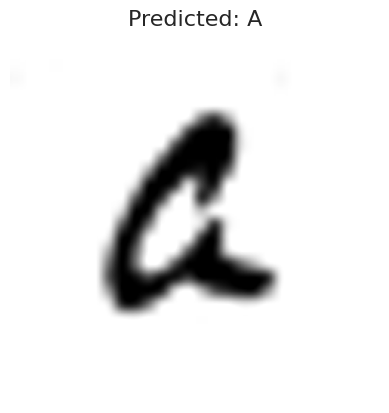

np.str_('A')

In [22]:
import joblib, cv2, matplotlib.pyplot as plt, numpy as np

model = joblib.load("final_svm_model.joblib")
pca = joblib.load("pca_transform.joblib")
encoder = joblib.load("label_encoder.joblib")

def predict_letter(image_path, image_size=(250, 250)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, image_size).reshape(1, -1) / 255.0
    pred = model.predict(pca.transform(img))
    letter = encoder.inverse_transform(pred)[0]
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap="gray")
    plt.title(f"Predicted: {letter}", fontsize=16)
    plt.axis("off")
    plt.show()
    return letter

predict_letter("converted_images/0000_a.png")